In [1]:
import sys
print(sys.executable)
import warnings
warnings.filterwarnings("ignore")

d:\Software\anaconda\envs\tf_env\python.exe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy import stats
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from dbm_util import DBMbuilder
from ssnp import SSNP
from tools_oop import *

In [3]:
# #函数
# class Clr (BaseEstimator,TransformerMixin):
#     def fit(self,x,y=None):
#         return self
#     def transform(self,x):
#         print(x)
#         xmean = stats.gmean(x,axis = 1)
#         back = np.log(x / xmean[:, np.newaxis])
#         return back

In [3]:
clr = StandardScaler()
scaler = MinMaxScaler()

# load data

In [4]:
# 读取数据
dataset = pd.read_excel(r"../Dataset/final/data_outliers_more2.xlsx")
print(dataset)

# 筛选非异常值数据
dataset = dataset[dataset["outliers"] == "Non-outlier"]

# 定义需要处理的元素列表
cols = [
    'GRAINTETYPE', 'Ce', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
    'Pr', 'Er', 'Tm', 'Yb', 'Lu', 'Th', 'U',"Nb","Y"
]
cols_ = cols[1:]

# 将元素列转换为数值类型
for col in cols_:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# 定义球粒陨石标准化值 (Boynton 1984)
chondrite = pd.DataFrame({
    'La': 0.31,
    'Ce': 0.808,
    'Pr': 0.122,
    'Nd': 0.6,
    'Sm': 0.195,
    'Eu': 0.0735,
    'Gd': 0.259
}, index=[1])

# 计算元素比值
dataset["Th/U"] = dataset["Th"] / dataset["U"]
dataset["Ce/U"] = dataset["Ce"] / dataset["U"]
dataset["U/Yb"] = dataset["U"] / dataset["Yb"]
dataset["Nb/Y"] = dataset["Nb"] / dataset["Y"]
# 计算Eu异常和Ce异常
dataset["Eu/Eu*"] = (dataset["Eu"] / chondrite["Eu"][1]) / np.sqrt(
    (dataset["Sm"] / chondrite["Sm"][1]) * (dataset["Gd"] / chondrite["Gd"][1])
)
dataset["Ce/Ce*"] = (dataset["Ce"] / chondrite["Ce"][1]) * \
    (dataset["Sm"] / chondrite["Sm"][1]) / np.square(dataset["Nd"] / chondrite["Nd"][1])
dataset

      Unnamed: 0         CITATION GRAINTETYPE  Sample Sample no.  inherit  \
0              0  Cao et al. 2017           S   ZNX–0    ZNX–0–1        0   
1              1  Cao et al. 2017           S   ZNX–0    ZNX–0–2        0   
2              2  Cao et al. 2017           S   ZNX–0    ZNX–0–3        0   
3              3  Cao et al. 2017           S   ZNX–0    ZNX–0–4        0   
4              4  Cao et al. 2017           S   ZNX–0    ZNX–0–5        0   
...          ...              ...         ...     ...        ...      ...   
2320        2321   Min Peng（2012）          A2  08HL07  08HL07-21        0   
2321        2322   Min Peng（2012）          A2  08HL07  08HL07-22        0   
2322        2323   Min Peng（2012）          A2  08HL07  08HL07-23        0   
2323        2324   Min Peng（2012）          A2  08HL07  08HL07-24        0   
2324        2325   Min Peng（2012）          A2  08HL07  08HL07-25        0   

                     Hostrock  genesis     Ce     Pr  ...     Ho     Er  \


,Unnamed: 0,CITATION,GRAINTETYPE,Sample,Sample no.,inherit,Hostrock,genesis,Ce,Pr,...,U,Nb,Y,outliers,Th/U,Ce/U,U/Yb,Nb/Y,Eu/Eu*,Ce/Ce*
1,1,Cao et al. 2017,S,ZNX–0,ZNX–0–2,0,Grainte,Grainte,53.5,0.05,...,2684.0,43.00,2519.0,Non-outlier,0.780179,0.019933,2.620326,0.017070,0.076614,439.296935
4,4,Cao et al. 2017,S,ZNX–0,ZNX–0–5,0,Grainte,Grainte,36.5,0.05,...,194.0,3.40,1026.0,Non-outlier,1.036082,0.188144,0.528322,0.003314,0.369854,459.533394
6,6,Cao et al. 2017,S,ZNX–0,ZNX–0–7,0,Grainte,Grainte,58.2,0.10,...,441.0,6.60,1158.0,Non-outlier,1.043084,0.131973,1.052506,0.005699,0.324446,258.568165
7,7,Cao et al. 2017,S,ZNX–0,ZNX–0–8,0,Grainte,Grainte,82.0,0.10,...,528.0,8.90,1965.0,Non-outlier,1.195076,0.155303,0.747240,0.004529,0.437402,238.737703
8,8,Cao et al. 2017,S,ZNX–0,ZNX–0–9,0,Grainte,Grainte,143.1,0.30,...,661.0,13.90,2166.0,Non-outlier,2.406959,0.216490,0.935201,0.006417,0.478907,178.420619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2321,Min Peng（2012）,A2,08HL07,08HL07-21,0,alkali feldspar granite,NaN,20.4,0.73,...,93.9,2.14,713.0,Non-outlier,1.006390,0.217252,0.424887,0.003001,0.122231,9.460269
2321,2322,Min Peng（2012）,A2,08HL07,08HL07-22,0,alkali feldspar granite,NaN,20.5,0.04,...,46.2,1.67,499.0,Non-outlier,1.281385,0.443723,0.286957,0.003347,0.115919,59.111324
2322,2323,Min Peng（2012）,A2,08HL07,08HL07-23,0,alkali feldspar granite,NaN,16.9,0.04,...,60.6,2.10,409.0,Non-outlier,1.132013,0.278878,0.473438,0.005134,0.083568,107.113592
2323,2324,Min Peng（2012）,A2,08HL07,08HL07-24,0,alkali feldspar granite,NaN,14.0,0.14,...,29.6,1.60,542.0,Non-outlier,1.527027,0.472973,0.188535,0.002952,0.182635,30.003726


In [8]:
# 定义包含所有特征的列表，包括原始元素和计算的比值
cols = [
    'GRAINTETYPE', 'Eu/Eu*', 'Ce/U', 'Nb', 'Th/U', 'Tb', 'Nb/Y', 'Ce', 'U/Yb', 'Pr', 'Ce/Ce*', 'Eu', 'Yb', 'U', 'Th'
]
# 获取除GRAINTETYPE外的所有特征
features_ = cols[1:]
print(features_)

# 选择指定列并处理数据
data = dataset.loc[:, cols]
data = data.dropna()  # 去除含空值的行

# 准备特征矩阵和标签
X = data.drop(['GRAINTETYPE'], axis=1).astype(float)  # 转换为浮点型
y = data['GRAINTETYPE']
X = clr.fit_transform(X)

# 打印数据信息
print(len(data))  # 打印数据行数
print(y.value_counts())  # 打印各类别的样本数量

['Eu/Eu*', 'Ce/U', 'Nb', 'Th/U', 'Tb', 'Nb/Y', 'Ce', 'U/Yb', 'Pr', 'Ce/Ce*', 'Eu', 'Yb', 'U', 'Th']
2009
GRAINTETYPE
I     710
S     515
A2    436
A1    348
Name: count, dtype: int64


In [9]:
# # 编码
from sklearn import preprocessing
from collections import Counter
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)
print(Counter(y))

[3 3 3 ... 1 1 1]
Counter({np.int64(2): 710, np.int64(3): 515, np.int64(1): 436, np.int64(0): 348})


In [10]:
from matplotlib.colors import ListedColormap

# 统一使用小写 HEX 并保证顺序一致
set2_palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
custom_cmap = ListedColormap(set2_palette)

Epoch 1/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - decoder_output_loss: 0.5131 - loss: 3.5300 - main_output_accuracy: 0.3259 - main_output_loss: 1.3188 - val_decoder_output_loss: 0.1472 - val_loss: 2.4493 - val_main_output_accuracy: 0.3860 - val_main_output_loss: 1.1459
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - decoder_output_loss: 0.1842 - loss: 2.2675 - main_output_accuracy: 0.5359 - main_output_loss: 1.0568 - val_decoder_output_loss: 0.1428 - val_loss: 1.9104 - val_main_output_accuracy: 0.6842 - val_main_output_loss: 1.0586
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - decoder_output_loss: 0.1816 - loss: 1.7560 - main_output_accuracy: 0.5903 - main_output_loss: 0.9475 - val_decoder_output_loss: 0.1422 - val_loss: 1.5596 - val_main_output_accuracy: 0.7895 - val_main_output_loss: 0.9834
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - decoder_output_loss: 0.1836 - loss: 1.4565 - main_output_accuracy: 0.6162 - main_output_loss: 0.8924 - val_decoder_output_loss: 

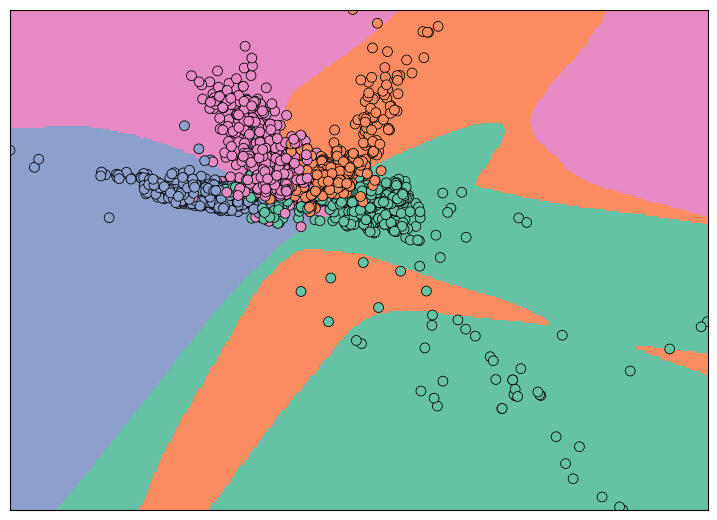

In [13]:
plt.figure(figsize=(9, 6.5))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sampler = SMOTE(random_state=42)
X_over, y_over = sampler.fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_over_scaled = scaler.fit_transform(X_over)
X_test_scaled = scaler.transform(X_test)
clf = SVC(kernel="rbf", C = 10.465, gamma = 8.715, probability=True)
# clf = RandomForestClassifier()
# clf = XGBClassifier(n_estimators = 177, learning_rate = 0.26, max_depth = 11, gamma = 0, colsample_bytree = 0.7)
ssnp = SSNP(epochs=500, patience=10)

ssnp.fit(X_over_scaled, y_over)

X_ssnp = ssnp.transform(X_over_scaled)
scaler2d = MinMaxScaler()
scaler2d.fit(X_ssnp)

clf.fit(X_over_scaled, y_over)
print(clf.score(X_over_scaled, y_over))

builder = DBMbuilder(clf, ssnp, scaler2d=scaler2d, scalernd=scaler)

ax = builder.plot_prob_map(cmap=custom_cmap)
kwargs  =   {'edgecolor':"k"}
ax = sns.scatterplot(x = scaler2d.transform(X_ssnp)[:, 0], y =scaler2d.transform(X_ssnp)[:, 1], hue=label_encoder.inverse_transform(y_over), hue_order=["A1","A2","I","S"],palette=set2_palette, 
                    alpha=1, s=50, **kwargs)
# ax.legend(labels=[r'$\text{A}_1$',r'$\text{A}_2$',"I","S"],ncol=1, fontsize=10)
ax.legend().remove()
# plt.savefig(f'../Picture/Fig 8/ssnp{g}.png', dpi=600)
# plt.savefig(f"../Picture/Fig 8/ssnp{g}.pdf", dpi=600)

In [ ]:
#split_Data - sampler - scaler - ssnp - scaler2d 
# scaler2d - ssnp - sclaer - sampler - split_Data

In [128]:
overlop_value = scaler2d.transform(X_ssnp)[(scaler2d.transform(X_ssnp)[:, 0] > 0.5) & (scaler2d.transform(X_ssnp)[:, 1] > 0.4)]
# print(overlop_value)
# scaler2d
origin_scaler2d = scaler2d.inverse_transform(overlop_value)
# ssnp
origin_ssnp = ssnp.inverse_transform(origin_scaler2d)
# scaler
origin_scaler = scaler.inverse_transform(origin_ssnp)
# sampler

origin_data = pd.DataFrame(origin_scaler, columns=X_train.columns)

rows_add = len(X_train) - len(origin_data)
print(rows_add)
zero_df = pd.DataFrame(np.zeros((rows_add, len(X_train.columns))), columns=X_train.columns)
origin_data = pd.concat([origin_data, zero_df], ignore_index=True)
origin_data = pd.DataFrame(origin_data, columns=X_train.columns)
mxsk = np.any(np.isclose(X_train,origin_data, rtol=1e-1, atol=1e-1),axis=1)
origin_data = X_train[mxsk]
origin_data = pd.DataFrame(origin_data, columns=X_train.columns)
# print(f"Found {len(origin_data)} matching points")
index = origin_data.index
data__ = dataset[dataset.index.isin(index)]
data___ = data__[data__["GRAINTETYPE"] == "A2"]
data__.to_csv("../Dataset/final/ssnp_A2.csv", index=False)
# Calculate proportions for each citation
for i in data___["CITATION"].unique():
    data0 = dataset[dataset["CITATION"] == i]
    data1 = data0[data0["GRAINTETYPE"] == "A2"]
    if len(data1) > 0:
        proportion = len(data___[data__["CITATION"] == i]) / len(data1)
        print(f"CITATION{i}  : {proportion:.2%}")
        print(len(data___[data__["CITATION"] == i]))
    for j in data___["Sample"].unique():
        data2 = data1[data1["Sample"] == j]
        if len(data2) > 0:
            proportion = len(data___[data__["Sample"] == j]) / len(data2)
            print(f"Sample {j}  : {proportion:.2%}")
            print(len(data___[data__["Sample"] == j]))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1082
CITATIONEl-Bialy（2013）  : 19.05%
4
Sample KI-1   : 19.05%
4
CITATIONFrederico Castro Jobim Vilalva2019  : 27.27%
6
Sample MR-186A  : 66.67%
4
Sample GUA-16  : 33.33%
1
Sample AT-15C  : 33.33%
1
CITATIONHong-Fei Zhang (2007)  : 17.65%
3
Sample WQ-354  : 17.65%
3
CITATIONHuan Li（2018）  : 20.00%
10
Sample XHL6-18  : 25.00%
4
Sample XHL5-16-2  : 20.00%
1
Sample XHL5-11  : 20.00%
2
Sample XHL6-2  : 16.67%
1
Sample XHL7-3  : 15.38%
2
CITATIONYuxiao Chen2016  : 16.30%
15
Sample SZY16  : 25.00%
1
Sample SZY21  : 10.00%
1
Sample SZY26  : 10.00%
1
Sample SZY35  : 15.79%
3
Sample SZY36  : 15.00%
3
Sample SZY39  : 27.27%
6
CITATIONXiaojun Zhang et.al 2022  : 56.25%
9
Sample DY19-13–1  : 50.00%
7
Sample 470–4  : 100.00%
1
Sample DY19-23–1  : 100.00%
1
CITATIONLiu et al., 2021 Lithos  : 22.22%
10
Sample 17LL056-1  : 34.62%
9
Sample 17LL115-1  : 14.29%
1
CITATIONLiu et al., 2019 AGS  : 30.77%
20
Sample 17JJL16  : 33.33%
7
Sample 17JJL24  : 23.53%
4
Sample 

# SVM classifier and SDBM

Eu/Eu*    0
Sm        0
Ce        0
Ce/U      0
Dy        0
U/Yb      0
Pr        0
Nb/Y      0
Lu        0
Th        0
dtype: int64

Epoch 1/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - decoder_output_loss: 0.6871 - loss: 3.2619 - main_output_accuracy: 0.3522 - main_output_loss: 1.3229 - val_decoder_output_loss: 0.6860 - val_loss: 2.8380 - val_main_output_accuracy: 0.0000e+00 - val_main_output_loss: 1.3294
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - decoder_output_loss: 0.6725 - loss: 2.3841 - main_output_accuracy: 0.5510 - main_output_loss: 0.9800 - val_decoder_output_loss: 0.6586 - val_loss: 2.1509 - val_main_output_accuracy: 0.5614 - val_main_output_loss: 0.9920
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - decoder_output_loss: 0.6671 - loss: 1.9418 - main_output_accuracy: 0.6360 - main_output_loss: 0.8369 - val_decoder_output_loss: 0.6608 - val_loss: 1.9643 - val_main_output_accuracy: 0.6228 - val_main_output_loss: 0.9966
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3

KeyboardInterrupt: 

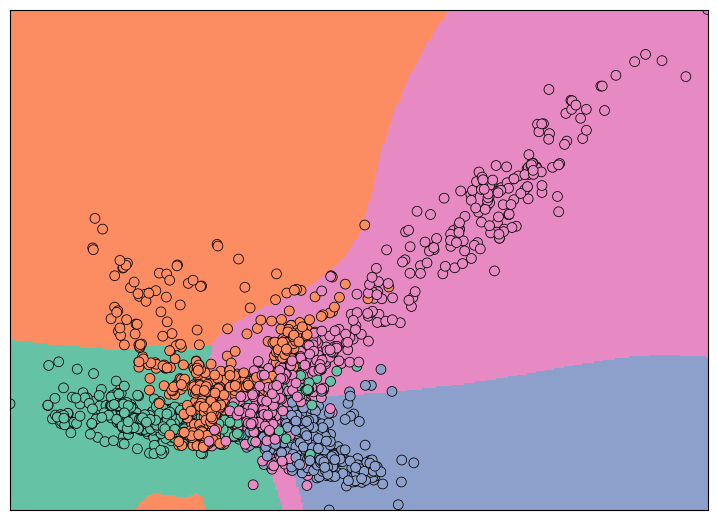

In [15]:
for g in range(1,2,1):
    plt.figure(figsize=(9, 6.5))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    sampler = SMOTE(random_state=42)
    X_over, y_over = sampler.fit_resample(X_train, y_train)
    print(X_over.isnull().sum())
    scaler = MinMaxScaler()
    X_over_scaled = scaler.fit_transform(X_over)
    X_test_scaled = scaler.transform(X_test)
    clf = SVC(kernel="rbf", C = 5.074, gamma = 8.123, probability=True)
    ssnp = SSNP(epochs=500, patience=10)

    ssnp.fit(X_over_scaled, y_over)

    X_ssnp = ssnp.transform(X_over_scaled)
    scaler2d = MinMaxScaler()
    scaler2d.fit(X_ssnp)

    clf.fit(X_over_scaled, y_over)
    print(clf.score(X_over_scaled, y_over))

    builder = DBMbuilder(clf, ssnp, scaler2d=scaler2d, scalernd=scaler)

    ax = builder.plot_prob_map(cmap=custom_cmap)
    kwargs  =   {'edgecolor':"k"}
    ax = sns.scatterplot(x = scaler2d.transform(X_ssnp)[:, 0], y =scaler2d.transform(X_ssnp)[:, 1], hue=label_encoder.inverse_transform(y_over), hue_order=["A1","A2","I","S"],palette=set2_palette, 
                        alpha=1, s=50, **kwargs)
    # ax.legend(labels=[r'$\text{A}_1$',r'$\text{A}_2$',"I","S"],ncol=1, fontsize=10)
    ax.legend().remove()
    plt.savefig(f'../Picture/Fig 8/ssnp{g}.png', dpi=600)
    plt.savefig(f"../Picture/Fig 8/ssnp{g}.pdf", dpi=600)

    plt.close()
    plt.figure(figsize=(9, 6.5))
    print(clf.score(X_test_scaled, y_test))
    X_ssnp_test = ssnp.transform(X_test_scaled)
    ax = builder.plot_prob_map(cmap=custom_cmap)
    for i in range(len(y_test)):
        if y_test[i]==0:
            s0 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#66C2A5', alpha=1, s=50, edgecolors='k')
        if y_test[i]==1:
            s1 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#FC8D62', alpha=1, s=50, edgecolors='k')
        if y_test[i]==2:
            s2 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#8da0cb', alpha=1, s=50, edgecolors='k')
        if y_test[i]==3:
            s3 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#e78ac3', alpha=1, s=50, edgecolors='k')
    ax.legend((s0, s1, s2, s3), ('A1 type', 'A2 type', 'I type', 'S type'))
    ax.legend().remove()
    plt.savefig(f"../Picture/Fig 8/ssnp_test{g}.png", dpi=600)
    plt.savefig(f"../Picture/Fig 8/ssnp_test{g}.pdf", dpi=600)
    plt.close()
    features = ['Eu/Eu*', 'Sm', 'Ce', 'Ce/U', 'Dy', 'U/Yb', 'Pr', 'Nb/Y', 'Lu', 'Th']

    explain = Explain(X_over_scaled, X_ssnp, columns=features, epsilon=0.2)
    scores = explain.get_confidence_scores()
    s = scores['confidence_normalized'].values * 100
    kwargs = {'edgecolor': 'k'}
    plt.figure(figsize=(9, 6.5))
    kwargs = {'edgecolor': 'k'}
    ax = builder.plot_prob_map(cmap=custom_cmap)
    ax = sns.scatterplot(
        x=scaler2d.transform(X_ssnp)[:, 0], 
        y=scaler2d.transform(X_ssnp)[:, 1], 
        hue=scores['color_plot'].values,
        size=s,  # Use the confidence scores for point sizes
        sizes=(50, 200),  # Define the range of point sizes
        **kwargs)
    plt.title('Feature Distribution')
    handles, labels = ax.get_legend_handles_labels()
    print(labels)
    print(handles)
    plt.legend(
        labels = labels[:6]
        , handles = handles[:6]
        , title='color_plot'
        , bbox_to_anchor=(0.85, 1)
        , loc='upper left'
    )
    plt.savefig(f"../Picture/Fig 8/A-MAP{g}.png", dpi=600)
    plt.savefig(f"../Picture/Fig 8/A-MAP{g}.pdf", dpi=600)
    plt.close()

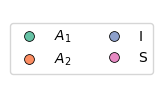

In [19]:
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
fig_legened = plt.figure(figsize=(1,1))
plt.legend(handles=handles, labels=[r'$A_1$','$A_2$',"I","S"], loc='center', ncol=2, fontsize=10)
plt.axis('off')
# plt.
plt.show()

# SDBM of testing set

0.900497512437811
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


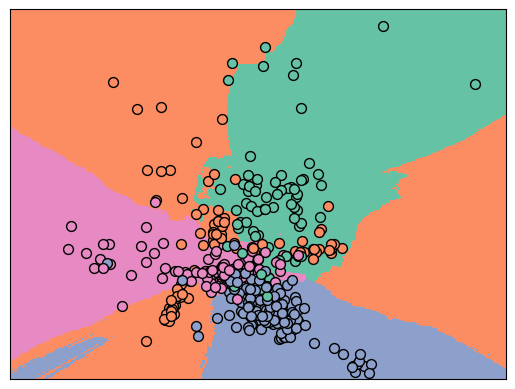

In [ ]:
print(clf.score(X_test_scaled, y_test))
X_ssnp_test = ssnp.transform(X_test_scaled)
ax = builder.plot_prob_map(cmap=custom_cmap)
for i in range(len(y_test)):
    if y_test[i]==0:
        s0 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#66C2A5', alpha=1, s=50, edgecolors='k')
    if y_test[i]==1:
        s1 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#FC8D62', alpha=1, s=50, edgecolors='k')
    if y_test[i]==2:
        s2 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#8da0cb', alpha=1, s=50, edgecolors='k')
    if y_test[i]==3:
        s3 = ax.scatter(scaler2d.transform(X_ssnp_test)[i, 0], scaler2d.transform(X_ssnp_test)[i, 1], c='#e78ac3', alpha=1, s=50, edgecolors='k')
ax.legend((s0, s1, s2, s3), ('A1 type', 'A2 type', 'I type', 'S type'))
ax.legend().remove()
plt.savefig("../Picture/Fig 8/ssnp_test3.png", dpi=600)
plt.savefig("../Picture/Fig 8/ssnp_test3.pdf", dpi=600)

In [ ]:
from collections import Counter

# A-MPs

['Lu', 'Nb', 'U/Yb', 'Eu/Eu*', 'Tb', 'others', '0', '15', '30', '45', '60']
[<matplotlib.lines.Line2D object at 0x000001F5C085B100>, <matplotlib.lines.Line2D object at 0x000001F5C085B520>, <matplotlib.lines.Line2D object at 0x000001F5C085B790>, <matplotlib.lines.Line2D object at 0x000001F5C085BA00>, <matplotlib.lines.Line2D object at 0x000001F5C0873790>, <matplotlib.lines.Line2D object at 0x000001F5C085BE20>, <matplotlib.lines.Line2D object at 0x000001F5C085E0D0>, <matplotlib.lines.Line2D object at 0x000001F5C085E340>, <matplotlib.lines.Line2D object at 0x000001F5C085E5B0>, <matplotlib.lines.Line2D object at 0x000001F5C085E820>, <matplotlib.lines.Line2D object at 0x000001F5C085EA90>]


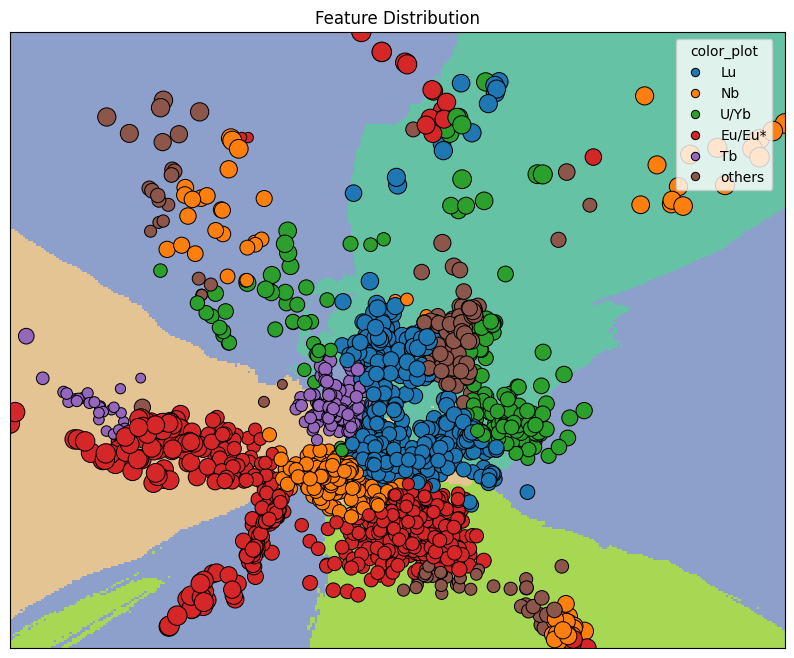

In [ ]:
# Plot the scatter plot with varying sizes
features = ['Sm', 'Eu/Eu*', 'Th', 'Nb', 'Nb/Y', 'Ce/U', 'Ce', 'Ce/Ce*'
            , 'Lu', 'Th/U', 'Tb', 'Eu', 'U/Yb'
            ]

explain = Explain(X_over_scaled, X_ssnp, columns=features, epsilon=0.2)
scores = explain.get_confidence_scores()
s = scores['confidence_normalized'].values * 100
kwargs = {'edgecolor': 'k'}
plt.figure(figsize=(10, 8))
kwargs = {'edgecolor': 'k'}
ax = builder.plot_prob_map(cmap=cm.Set2)
ax = sns.scatterplot(
    x=scaler2d.transform(X_ssnp)[:, 0], 
    y=scaler2d.transform(X_ssnp)[:, 1], 
    hue=scores['color_plot'].values,
    size=s,  # Use the confidence scores for point sizes
    sizes=(50, 200),  # Define the range of point sizes
    **kwargs)
plt.title('Feature Distribution')
handles, labels = ax.get_legend_handles_labels()
print(labels)
print(handles)
plt.legend(
    labels = labels[:6]
    , handles = handles[:6]
    , title='color_plot'
    , bbox_to_anchor=(0.85, 1)
    , loc='upper left'
)
plt.savefig("../Picture/Fig 8/A-MAP3.png", dpi=600)
plt.savefig("../Picture/Fig 8/A-MAP3.pdf", dpi=600)

In [ ]:
x = pd.DataFrame([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]],columns=['A','B','C','D','E'])
print(x)
print(x.describe())
x = MinMaxScaler().fit_transform(x)
print(x)

    A   B   C   D   E
0   1   2   3   4   5
1   6   7   8   9  10
2  11  12  13  14  15
          A     B     C     D     E
count   3.0   3.0   3.0   3.0   3.0
mean    6.0   7.0   8.0   9.0  10.0
std     5.0   5.0   5.0   5.0   5.0
min     1.0   2.0   3.0   4.0   5.0
25%     3.5   4.5   5.5   6.5   7.5
50%     6.0   7.0   8.0   9.0  10.0
75%     8.5   9.5  10.5  11.5  12.5
max    11.0  12.0  13.0  14.0  15.0
[[0.  0.  0.  0.  0. ]
 [0.5 0.5 0.5 0.5 0.5]
 [1.  1.  1.  1.  1. ]]
